In [1]:
import os
import time
import uuid
import cv2

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# Test de las images

In [3]:
images = tf.data.Dataset.list_files('images\\train\\images\\*.jpg')

In [4]:
"""Carga de PATH a IMAGENES"""
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)

In [6]:
image_generator = images.batch(4).as_numpy_iterator() #Agarro 4 fotos

In [7]:
plot_images = image_generator.next() #Agarra unas 4 fotos nuevas

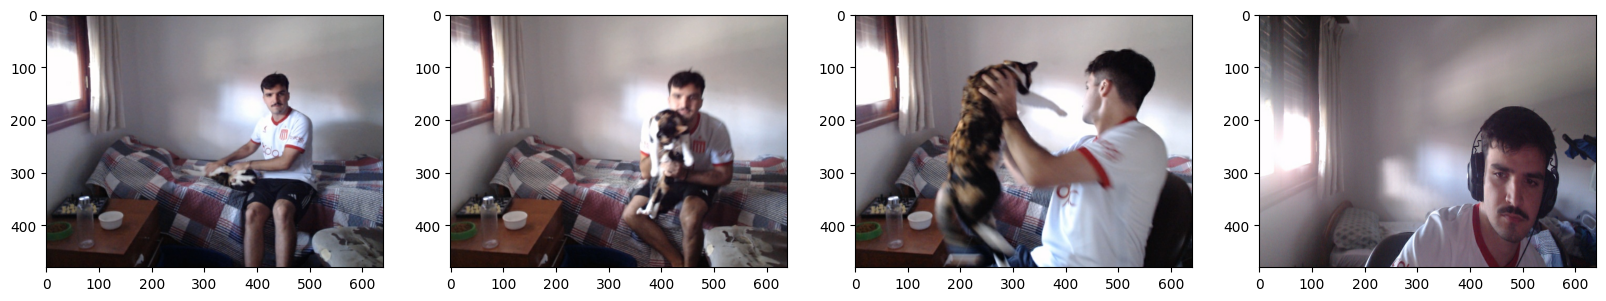

In [8]:
"""Mira que lindaaaaaaaaaaa"""
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Ahora viene la parte funny Augmentation

Por cada foto que tengamos en cada carpeta (TEST, VAL, TRAIN) se van a crear 60 fotos con atributos distintos, gamma, flip, RGB, brillo, contraste

In [9]:
import albumentations as alb

In [10]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)
                        ], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [11]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('images', partition, 'images')):
        img = cv2.imread(os.path.join('images', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('images', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['diana'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Pequeño test de como funcionaria la imagen alterada con su respectivo label

In [9]:
img = cv2.imread(os.path.join('aug_data','train', 'images','WIN_20230214_21_56_17_Pro.8.jpg'))
with open(os.path.join('aug_data', 'train', 'labels', 'WIN_20230214_21_56_17_Pro.8.json'), 'r') as f:
    label = json.load(f)
    

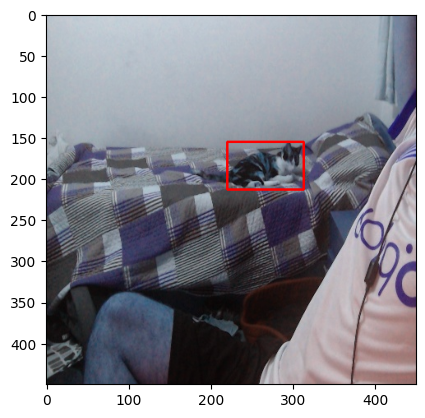

In [11]:
cv2.rectangle(img, 
              tuple(np.multiply(label['bbox'][:2], [450,450]).astype(int)),
              tuple(np.multiply(label['bbox'][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(img)

# Fusionamos todas las images con sus labels respectivos para empezar el entrenamiento

In [12]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [14]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [15]:
"""Extrae la clase y el recuadro de cada foto"""
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5760, 5760, 1860, 1860, 1680, 1680)

In [20]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [21]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [22]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

# Es complicado y facil a la vez... creamos el "modelo"

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [24]:
vgg = VGG16(include_top=False)

In [25]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [26]:
dianatracker = build_model()

In [27]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [30]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [31]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [32]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [56]:
class DianaTracker(Model): 
    def __init__(self, cattracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = cattracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

# Instancio el modelo y comienzo entrenamiento

In [34]:
model = DianaTracker(dianatracker)

In [35]:
model.compile(opt, classloss, regressloss)

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
720/720 [==============================] - 3134s 4s/step - total_loss: 1.5618 - class_loss: 0.3816 - regress_loss: 1.3710 - val_total_loss: 1.3261 - val_class_loss: 0.6034 - val_regress_loss: 1.0244
Epoch 2/20
720/720 [==============================] - 1312s 2s/step - total_loss: 0.3470 - class_loss: 0.1012 - regress_loss: 0.2964 - val_total_loss: 0.4988 - val_class_loss: 0.0028 - val_regress_loss: 0.4974
Epoch 3/20
720/720 [==============================] - 1370s 2s/step - total_loss: 0.1128 - class_loss: 0.0325 - regress_loss: 0.0966 - val_total_loss: 0.3444 - val_class_loss: 0.0667 - val_regress_loss: 0.3110
Epoch 4/20
720/720 [==============================] - 1503s 2s/step - total_loss: 0.0750 - class_loss: 0.0187 - regress_loss: 0.0657 - val_total_loss: 0.7455 - val_class_loss: 0.4394 - val_regress_loss: 0.5258
Epoch 5/20
720/720 [==============================] - 1536s 2s/step - total_loss: 0.0368 - class_loss: 0.0081 - regress_loss: 0.0327 - val_total_loss: 0.7354 - 

Funciono?? Let's find out

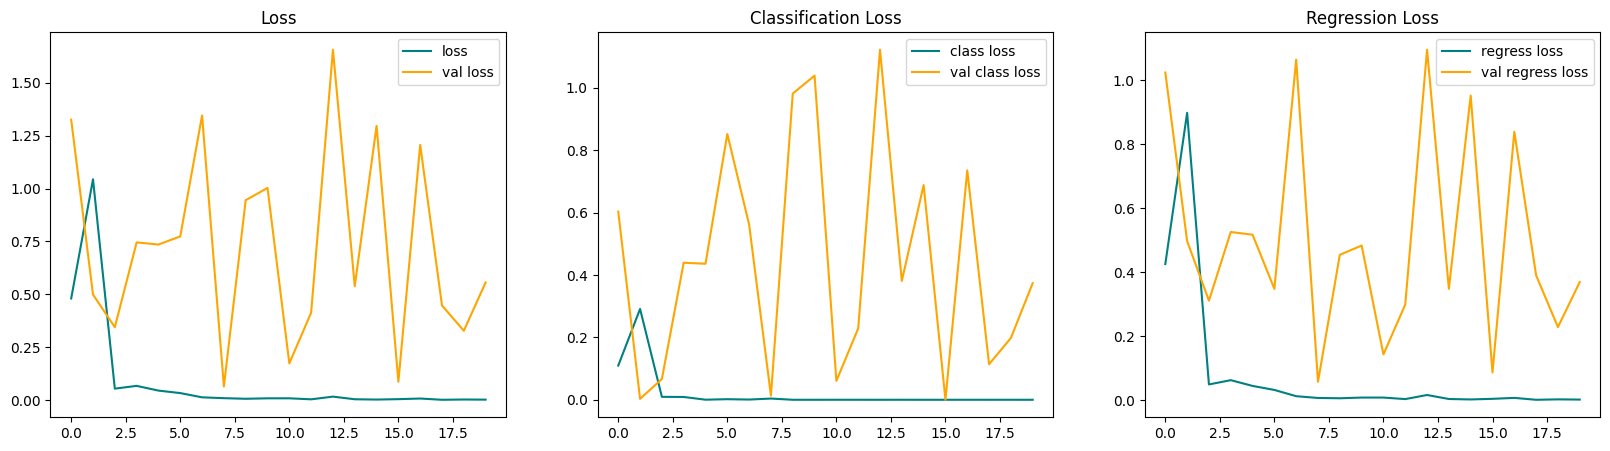

In [40]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Kind off...

# Guardamos el modelo y lo testeamos!

In [41]:
from tensorflow.keras.models import load_model

In [42]:
dianatracker.save('dianatrackerv2.h5')

In [43]:
dianatracker = load_model('dianatrackerv2.h5')

In [44]:
test_data = test.as_numpy_iterator()

In [60]:
test_sample = test_data.next()

In [61]:
yhat = dianatracker.predict(test_sample[0])

1/1 [==============================] - 0s 338ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


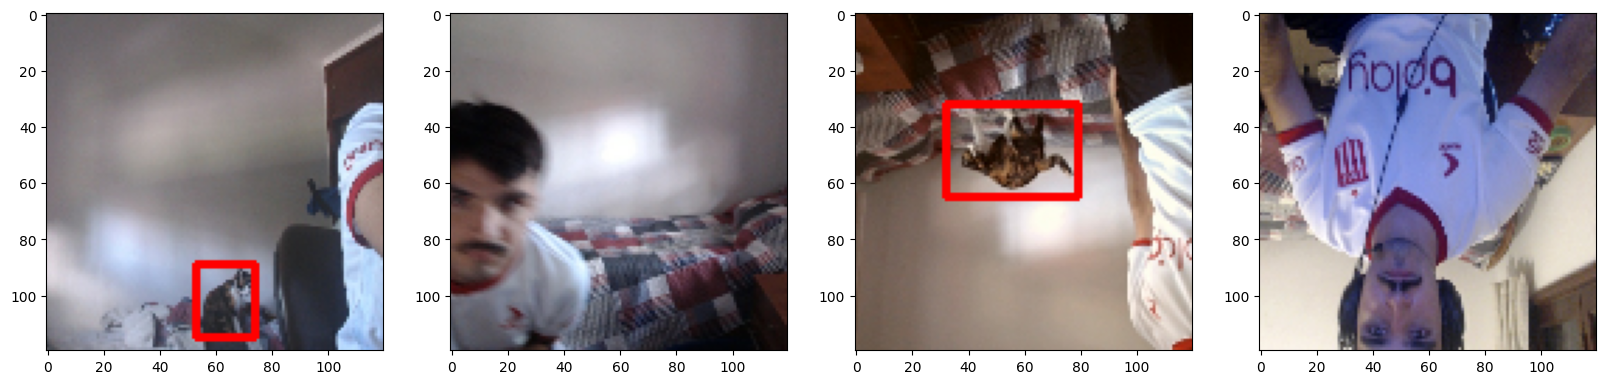

In [62]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

AHHHHHHH FUNCIONA!!!!!!!!!11

# Test con camara real!

In [64]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = dianatracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'diana{}'.format(yhat[0]), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 165ms/step
